# Deepfake Audio Detection - Generator Version

**Version:** Generator Linked (Solves Memory/InternalError)

This notebook implements a **Data Generator** (`tf.keras.utils.Sequence`) pipeline. Unlike the previous version which loaded all 13,000+ files into RAM (causing crashes), this version loads audio files in small batches *during* training. 

**Preserved Features:**
- **Architecture:** CNN-BiLSTM (Same as before)
- **Preprocessing:** Noise Reduction, Random Cropping, Padding
- **Augmentation:** Audiomentations (Noise, Pitch, Time Stretch) applied on-the-fly
- **GPU Support:** Full GPU acceleration for training

In [1]:
import os
import ctypes
import sys
from pathlib import Path
from datetime import datetime
import json
import random

import numpy as np
import librosa
import noisereduce as nr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import audiomentations as am

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers
from tensorflow.keras.utils import Sequence

c:\DeepfakeProject\venv_gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ============================================================================
# GPU Configuration
# ============================================================================

# Load CUDA DLLs for GPU acceleration
cuda_path = r"C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.0\bin"
for dll in ["cudart64_110.dll", "cudnn64_8.dll", "zlibwapi.dll"]:
    dll_path = os.path.join(cuda_path, dll)
    if os.path.exists(dll_path):
        try:
            ctypes.CDLL(dll_path)
        except Exception:
            pass

# Enable GPU memory growth to avoid OOM errors
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

print(f"TensorFlow Version: {tf.__version__}")
print(f"GPUs available: {len(gpus)}")

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

TensorFlow Version: 2.10.0
GPUs available: 1


In [3]:
# ============================================================================
# Configuration
# ============================================================================

CONFIG = {
    # Audio processing parameters
    'sample_rate': 16000,          # Standard speech sampling rate
    'min_duration': 3.0,           # Minimum clip length (seconds)
    'max_duration': 10.0,          # Maximum clip length (seconds)
    'n_mels': 128,                 # Number of mel frequency bands
    'n_fft': 2048,                 # FFT window size
    'hop_length': 512,             # Hop length for STFT
    'noise_reduction': 0.8,        # Noise reduction strength (0-1)
    
    # Training hyperparameters
    'batch_size': 16,              # Kept small for stability
    'epochs': 50,
    'learning_rate': 0.0001,
    # Note: class_weight is handled differently in generators or via 'class_weight' arg in fit
    
    # Regularization
    'l2_reg': 0.001,               # L2 regularization coefficient
    
    # Data splits
    'validation_split': 0.15,      # 15% for validation
    'test_split': 0.15,            # 15% for testing
    
    # Dataset limits
    'max_samples_per_class': 10000,  # Limit files per class per split
}

In [4]:
# ============================================================================
# Data Augmentation & Preprocessing Helpers
# ============================================================================

# Augmentation pipeline for training robustness
augmentation_pipeline = am.Compose([
    am.AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),  # Random noise
    am.TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),  # Speed variation
    am.PitchShift(min_semitones=-4, max_semitones=4, p=0.5),  # Pitch variation
])

def apply_augmentation(audio: np.ndarray, sr: int = 16000) -> np.ndarray:
    """Apply augmentation pipeline to audio signal."""
    try:
        if audio.dtype != np.float32:
            audio = audio.astype(np.float32)
        return augmentation_pipeline(samples=audio, sample_rate=sr)
    except Exception:
        return audio

def load_audio(file_path: str, sr: int = 16000, 
               min_dur: float = 3.0, max_dur: float = 10.0) -> tuple:
    """
    Load audio with variable-length random cropping.
    Prevents model from learning fixed temporal positions.
    """
    try:
        y, _ = librosa.load(file_path, sr=sr, duration=max_dur)
        target_length = int(np.random.uniform(min_dur, max_dur) * sr)
        
        if len(y) >= target_length:
            # Random crop from audio
            start = np.random.randint(0, len(y) - target_length + 1)
            y = y[start:start + target_length]
        else:
            # Zero padding for short clips
            y = np.pad(y, (0, target_length - len(y)), mode='constant')
        
        return y, target_length / sr
    except Exception:
        return None, 0

def extract_features(audio: np.ndarray, sr: int = 16000, 
                    n_mels: int = 128, apply_nr: bool = True) -> np.ndarray:
    """
    Extract normalized mel-spectrogram features.
    """
    try:
        # Apply noise reduction
        if apply_nr:
            audio = nr.reduce_noise(y=audio, sr=sr, stationary=True, 
                                   prop_decrease=CONFIG['noise_reduction'])
        
        # Compute mel-spectrogram
        mel_spec = librosa.feature.melspectrogram(
            y=audio, sr=sr, n_mels=n_mels,
            n_fft=CONFIG['n_fft'], hop_length=CONFIG['hop_length']
        )
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        
        # Per-sample normalization
        mel_spec_norm = (mel_spec_db - mel_spec_db.min()) / \
                       (mel_spec_db.max() - mel_spec_db.min() + 1e-8)
        
        return mel_spec_norm
    except Exception:
        return None

In [5]:
# ============================================================================
# Data Generator Implementation (The Fix)
# ============================================================================

class DeepfakeDataset(Sequence):
    """
    Memory-efficient data generator. 
    Loads audio files in batches ON-THE-FLY instead of all at once.
    """
    def __init__(self, file_paths, labels, batch_size=16, 
                 config=CONFIG, augment=False, shuffle=True):
        self.file_paths = file_paths
        self.labels = labels
        self.batch_size = batch_size
        self.config = config
        self.augment = augment
        self.shuffle = shuffle
        
        # Calculate max width for padding (based on max_duration)
        # 10s * 16000sr / 512hop ~= 313 frames
        self.max_width = int(np.ceil((config['max_duration'] * config['sample_rate']) / config['hop_length']))
        
        # Initial shuffle
        self.on_epoch_end()

    def __len__(self):
        """Number of batches per epoch"""
        return int(np.ceil(len(self.file_paths) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data"""
        # Generate indexes of the batch
        start_idx = index * self.batch_size
        end_idx = min((index + 1) * self.batch_size, len(self.file_paths))
        indexes = self.indexes[start_idx:end_idx]

        # Find list of IDs and Labels
        batch_paths = [self.file_paths[k] for k in indexes]
        batch_labels = [self.labels[k] for k in indexes]

        return self.__data_generation(batch_paths, batch_labels)

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        self.indexes = np.arange(len(self.file_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_paths, batch_labels):
        """Generates data containing batch_size samples"""
        X = []
        y = []

        for i, file_path in enumerate(batch_paths):
            # Load audio
            try:
                audio, _ = load_audio(str(file_path), sr=self.config['sample_rate'],
                                     min_dur=self.config['min_duration'],
                                     max_dur=self.config['max_duration'])
            except Exception as e:
                print(f'Error loading file {file_path}: {e}')
                continue
                
            # Augmentation (Only if enabled, usually for real class in training)
            # Logic: If augment=True, we randomly decide to augment or not, 
            # OR we can enforce it. Here keeping it simple: if augment=True, do it.
            if self.augment:
                # Apply augmentation with 50% chance if set in pipeline, 
                # but here the pipeline manages probabilities internally.
                audio = apply_augmentation(audio, sr=self.config['sample_rate'])

            # Extract features
            features = extract_features(audio, sr=self.config['sample_rate'],
                                       n_mels=self.config['n_mels'])
            
            if features is not None:
                # Pad to max_width
                if features.shape[1] < self.max_width:
                    pad_width = self.max_width - features.shape[1]
                    features = np.pad(features, ((0, 0), (0, pad_width)), mode='constant')
                else:
                    features = features[:, :self.max_width]
                
                X.append(features)
                y.append(batch_labels[i])

        # Convert to numpy arrays
        X = np.array(X)[..., np.newaxis] # (Batch, Mel, Time, 1)
        y = np.array(y)
        
        # Handle potential empty batch (very rare)
        if len(X) == 0:
             return np.zeros((0, 128, self.max_width, 1)), np.zeros((0,))

        return X, y

In [6]:
# ============================================================================
# File Gathering (PROTOCOL AWARE - NO DATA LEAKAGE)
# ============================================================================

def get_files_from_split(split_name, max_samples=None):
    """
    Loads files ONLY from a specific split folder (e.g., 'train', 'dev', 'eval').
    Ensures ZERO contamination between Training and Test data.
    """
    file_paths = []
    labels = []
    
    data_dir = Path('data/dataset') / split_name
    if not data_dir.exists():
        print(f"Warning: {split_name} directory not found!")
        return np.array([]), np.array([])
    
    for label_name, label_idx in [('real', 0), ('fake', 1)]:
        class_dir = data_dir / label_name
        if not class_dir.exists(): continue
        
        features = list(class_dir.glob('*.flac'))
        
        # Optional: Limit samples for faster prototyping
        if max_samples:
            features = features[:max_samples]
            
        file_paths.extend(features)
        labels.extend([label_idx] * len(features))
        
    return np.array(file_paths), np.array(labels)

print("Gathering files respecting strict ASVspoof Protocol...")

# 1. LOAD TRAIN (Seen Speakers)
print("Loading TRAIN set...")
X_train_paths, y_train_labels = get_files_from_split('train', max_samples=CONFIG['max_samples_per_class'])

# 2. LOAD DEV (Validation - Unseen Speakers in Logic Access / Seen in Physical)
# For ASVspoof 2019 LA, Dev speakers are distinct from Train.
print("Loading DEV (Validation) set...")
X_val_paths, y_val_labels = get_files_from_split('dev', max_samples=CONFIG['max_samples_per_class'])

# 3. LOAD EVAL (Test - Completely Unseen Speakers & Attacks)
print("Loading EVAL (Test) set...")
X_test_paths, y_test_labels = get_files_from_split('eval', max_samples=CONFIG['max_samples_per_class'])

# Verify we have data
if len(X_train_paths) == 0:
    raise ValueError("No training data found! Did you run prepare_dataset.py?")

print(f"Train files: {len(X_train_paths)} (Used for Optimization)")
print(f"Val files:   {len(X_val_paths)} (Used for Checkpointing)")
print(f"Test files:  {len(X_test_paths)} (Used for Final Score)")

# Calculate Class Weights based on TRAINING data only
total = len(y_train_labels)
pos = sum(y_train_labels)
neg = total - pos
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}
print(f"Class Weights: {class_weight}")

Gathering files respecting strict ASVspoof Protocol...
Loading TRAIN set...
Loading DEV (Validation) set...
Loading EVAL (Test) set...
Train files: 20000 (Used for Optimization)
Val files:   12548 (Used for Checkpointing)
Test files:  17355 (Used for Final Score)
Class Weights: {0: 1.0, 1: 1.0}


In [7]:
# ============================================================================
# Instantiate Generators
# ============================================================================

train_gen = DeepfakeDataset(
    X_train_paths, y_train_labels, 
    batch_size=CONFIG['batch_size'],
    augment=True,  # Augmentation enabled for training
    shuffle=True
)

val_gen = DeepfakeDataset(
    X_val_paths, y_val_labels, 
    batch_size=CONFIG['batch_size'], 
    augment=False, 
    shuffle=False
)

test_gen = DeepfakeDataset(
    X_test_paths, y_test_labels, 
    batch_size=CONFIG['batch_size'], 
    augment=False, 
    shuffle=False
)

print("Generators ready.")

Generators ready.


In [8]:
# ============================================================================
# Model Architecture
# ============================================================================

def build_model(input_shape: tuple) -> models.Model:
    """
    Construct CNN-BiLSTM architecture with regularization.
    """
    inputs = layers.Input(shape=input_shape)
    
    # CNN Block 1
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(CONFIG['l2_reg']))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)
    
    # CNN Block 2
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(CONFIG['l2_reg']))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)
    
    # CNN Block 3
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(CONFIG['l2_reg']))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)
    
    # Reshape for LSTM
    shape = x.shape
    x = layers.Reshape((shape[1], shape[2] * shape[3]))(x)
    
    # BiLSTM Blocks
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Bidirectional(layers.LSTM(64))(x)
    x = layers.Dropout(0.3)(x)
    
    # Dense Blocks
    x = layers.Dense(128, activation='relu',
                     kernel_regularizer=regularizers.l2(CONFIG['l2_reg']))(x)
    x = layers.Dropout(0.4)(x)
    
    x = layers.Dense(64, activation='relu',
                     kernel_regularizer=regularizers.l2(CONFIG['l2_reg']))(x)
    x = layers.Dropout(0.4)(x)
    
    # Output layer
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    return models.Model(inputs=inputs, outputs=outputs)

In [9]:
# ============================================================================
# Build and Train (Using Generator) - RESUME CAPABLE
# ============================================================================
import pandas as pd
import glob
import pathlib

# Determine input shape from generator config
# (128, max_width, 1)
input_shape = (CONFIG['n_mels'], train_gen.max_width, 1)
model = build_model(input_shape)

# Compile FIRST to ensure metrics are ready
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=CONFIG['learning_rate']),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

model.summary()

# --- RESUME LOGIC ---
# Search for the latest existing model directory that has a checkpoint
model_dirs = sorted(glob.glob("models/model_*"), reverse=True) # Newest first
resume_dir = None

print(f"Checking {len(model_dirs)} model directories for resume candidates...")

for d in model_dirs:
    checkpoint = os.path.join(d, "model.keras")
    log = os.path.join(d, "training_log.csv")
    if os.path.exists(checkpoint) and os.path.exists(log):
        try:
            # Verify log isn't empty
            df_check = pd.read_csv(log)
            if not df_check.empty:
                resume_dir = d
                break
        except:
            continue

initial_epoch = 0
if resume_dir:
    print(f"Found valid resume directory: {resume_dir}")
    checkpoint_path = os.path.join(resume_dir, "model.keras")
    log_path = os.path.join(resume_dir, "training_log.csv")
    
    try:
        # 1. Load Weights
        print(f"Loading weights from {checkpoint_path}...")
        model.load_weights(checkpoint_path)
        
        # 2. Find last epoch
        df_log = pd.read_csv(log_path)
        last_epoch = df_log['epoch'].max()
        initial_epoch = last_epoch + 1
        print(f"Resuming from epoch {initial_epoch}...")
        
        # Keep saving to the SAME directory
        model_dir = pathlib.Path(resume_dir)
        
    except Exception as e:
        print(f"Error resuming: {e}. Starting fresh.")
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        model_dir = pathlib.Path('models') / f'model_{timestamp}'
        model_dir.mkdir(parents=True, exist_ok=True)
else:
    print("No valid previous model found. Starting fresh.")
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    model_dir = pathlib.Path('models') / f'model_{timestamp}'
    model_dir.mkdir(parents=True, exist_ok=True)

# Callbacks
callback_list = [
    callbacks.ModelCheckpoint(str(model_dir / 'model.keras'), 
                             monitor='val_loss', save_best_only=True),
    callbacks.EarlyStopping(monitor='val_loss', patience=5, 
                           restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                               patience=3, min_lr=1e-7), # Lower patience slightly
    callbacks.CSVLogger(str(model_dir / 'training_log.csv'), append=True) # APPEND MODE
]

print(f"Training will save to: {model_dir}")
print(f"Starting/Resuming training from epoch {initial_epoch}...")

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=CONFIG['epochs'],
    initial_epoch=initial_epoch, # Key for resuming
    class_weight=class_weight,
    callbacks=callback_list,
    verbose=1
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 313, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 313, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 128, 313, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 156, 32)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 156, 32)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 156, 64)       18496 

Evaluating model...
1085/1085 [==============================] - 993s 914ms/step
Preds: 17355, True: 17355

Classification Report:
              precision    recall  f1-score   support

        Real       0.94      0.90      0.92      7355
        Fake       0.93      0.96      0.94     10000

    accuracy                           0.93     17355
   macro avg       0.94      0.93      0.93     17355
weighted avg       0.93      0.93      0.93     17355



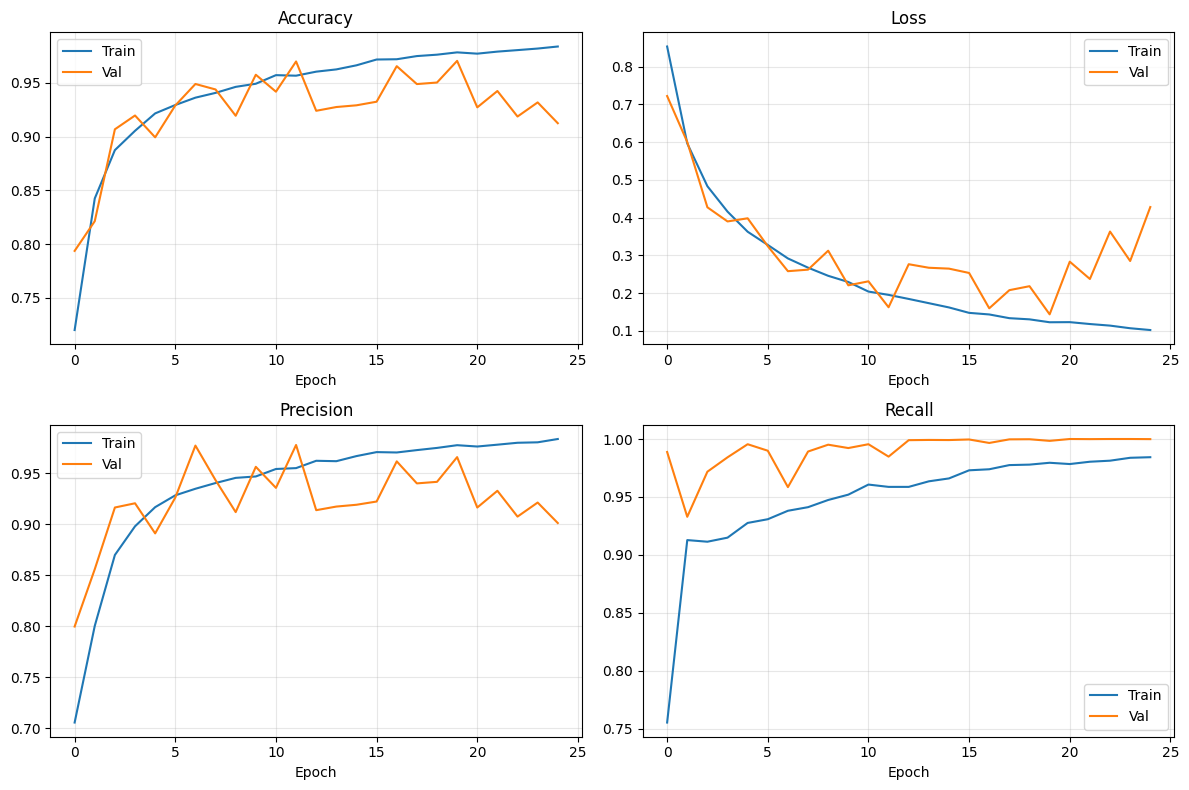

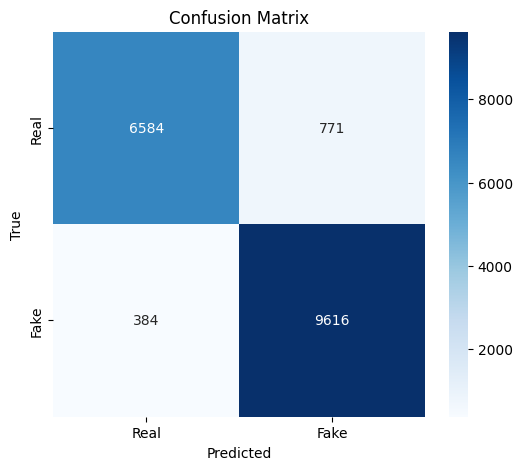

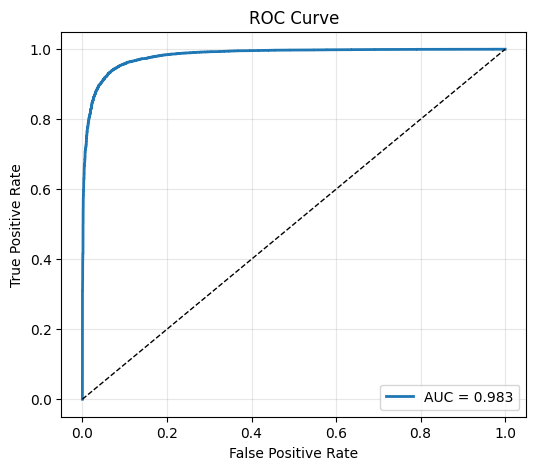

In [10]:
# ============================================================================
# Evaluation
# ============================================================================

print("Evaluating model...")
# Predict using test generator
y_pred_prob = model.predict(test_gen)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Get True Labels from test generator (ensure order matches)
# Since shuffle=False for test_gen, we can just grab labels from internal list,
# BUT we must be careful about batching. 
# Safest way is to iterate generator or access ground truth directly if aligned.
# Because we passed `X_test_paths` and `y_test_labels` directly to generator,
# and shuffle=False, `y_test_labels` should align with predictions if batch count matches.
# However, generator might truncate or pad last batch depending on implementation.
# Our generator implementation handles last batch correctly.

# Let's verify lengths
print(f"Preds: {len(y_pred)}, True: {len(y_test_labels)}")

# If lengths mismatch slightly due to batching (unlikely with this Code), align them.
y_test_eval = y_test_labels[:len(y_pred)]

print("\nClassification Report:")
print(classification_report(y_test_eval, y_pred, target_names=['Real', 'Fake']))

# Visualization: Training History
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for idx, metric in enumerate(['accuracy', 'loss', 'precision', 'recall']):
    ax = axes[idx // 2, idx % 2]
    # History keys might have 'precision_X' if not named explicitly, 
    # but we passed object instances without names, so they default to 'precision', 'recall'.
    # Let's handle potential key variations safely by checking history.history.keys()
    keys = history.history.keys()
    metric_key = next((k for k in keys if metric in k and 'val' not in k), metric)
    val_key = f"val_{metric_key}"
    
    if metric_key in history.history:
        ax.plot(history.history[metric_key], label='Train')
        if val_key in history.history:
            ax.plot(history.history[val_key], label='Val')
        ax.set_title(metric.capitalize())
        ax.set_xlabel('Epoch')
        ax.legend()
        ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Visualization: Confusion Matrix
cm = confusion_matrix(y_test_eval, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title('Confusion Matrix')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

# Visualization: ROC Curve
fpr, tpr, _ = roc_curve(y_test_eval, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, lw=2, label=f'AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()